Иногда можно столкнуться с отсутствием данных, например когда вы обрабатываете показания счётчика потребления горячей и холодной воды, а он по какой-то причине не работал несколько дней. Пропуски могут быть заполнены значениями NaN или нулями.

Взгляните на график ниже: за два дня (конец декабря и начало января) данные отсутствуют (они равны нулю) — из-за этого образуются спады до 0 в районе января.

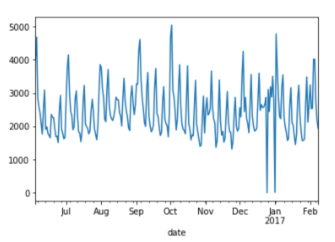

Хотим ли мы, чтобы модель, которая должна предсказывать объём потребления воды, учитывала эти значения, равные нулю? Очевидно, нет. Значит, нам нужно каким-то образом заполнить пропуски, причём заполнение нулями нам не подходит, а заполнение средним — тоже не самая эффективная идея.

А что, если у нас есть показания счётчика по дням, а заказчик хочет получить прогноз по часам? Тогда нам снова нужно как-то заполнить возникающие пропуски для часов.

Знакомьтесь — перед нами проблемы upsampling и downsampling на временных рядах.

Upsampling — это увеличение частоты выборки (повышение частоты дискретизации), например с минут до секунд. Также upsampling применяют для заполнения пропусков неизвестных значений. Для этой цели мы будем использовать интерполяцию.

Downsampling — это уменьшение частоты выборки, например с дней до месяцев.

DOWNSAMPLING

Начнём с простого — с downsampling.

По своей сути, downsampling — это перегруппировка. Мы можем сгруппировать значения, полученные по дням, в значения, полученные за месяц, путём использования метода groupby(). Однако существует ещё один встроенный в DataFrame метод с чуть более широким функционалом — resample(). Этот метод позволяет делать нестандартные группировки, такие как «за три дня» или «за каждые шесть секунд», то есть вы можете выбрать свой интервал группировки и получить результат, написав одну строку кода. Вызывать метод resample необходимо у датафрейма, в качестве индекса у которого используются даты в формате datetime. Например, если наш временной ряд с показаниями счетчика по потреблению воды изначально сгруппирован по дням, применив к нему resample, можно получить:

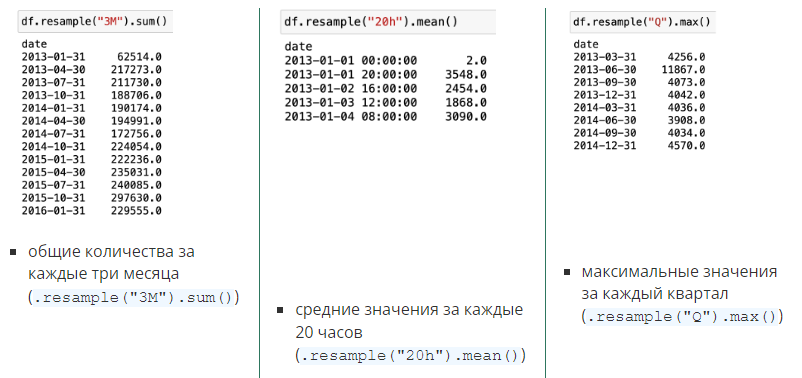

Дальше уже можно работать над построением модели.

Правила группировки (Q, H, M и др.) — это сокращения, используемые в работе с типом данных Timestamp. Полный перечень правил группировки можно найти в документации (таблица Date Offset).

Теперь пора переходить к upsampling. Но прежде рассмотрим понятие, которое мы уже упоминали выше, — «интерполяция».

ИНТЕРПОЛЯЦИЯ

Говоря простым языком, интерполяция — это нахождение некоторых промежуточных значений по функции, описывающей поведение данных. То есть если мы найдём такую функцию, значения которой будут совпадать с уже известными нам значениями, то можно предположить, что она поможет верно или приблизительно восстановить для нас неизвестные значения.

Существуют несколько способов нахождения этой функции, и интерполяция может быть выполнена с помощью:

линейной функции,

многочлена Лагранжа,

интерполяционной формулы Ньютона,

семейства сплайн-функций.

Если вы хотите подробно познакомиться с математикой, которая лежит в основе этих способов, рекомендуем вам прочитать книгу «Интерполяция. Методы и компьютерные технологии их реализации» А. М. Половко и П. Н. Бутусова.

UPSAMPLING

Для реализации upsampling на практике мы будем использовать уже известный нам метод resample, чтобы декомпозировать данные, например от дня к часам, а затем воспользуемся встроенным методом interpolate(), который принимает в качестве аргумента указание метода интерполяции: 'linear', 'nearest', 'spline', 'barycentric', 'polynomial' и другие. То есть сначала мы применяем к данным resample() с параметром h (час), а затем вместо агрегирующей функции sum/mean и др. применяем interpolate('linear'), чтобы выполнить линейную интерполяцию.


Пример результата выполнения функции — ниже. Мы можем применить её к одному из ранее использованных в модуле временных рядов.

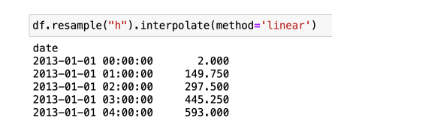

В следующем юните вы попробуете осуществить декомпозицию upsampling и downsampling на практике, но прежде давайте закрепим полученные знания с помощью небольшого теста ↓

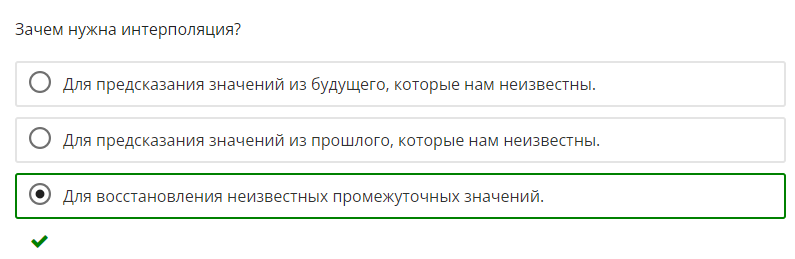

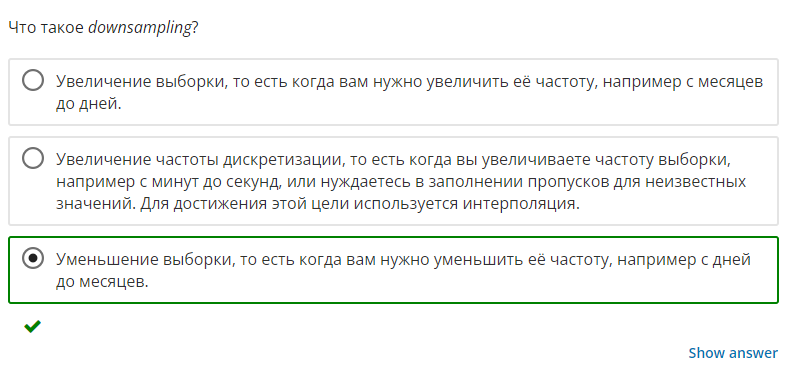

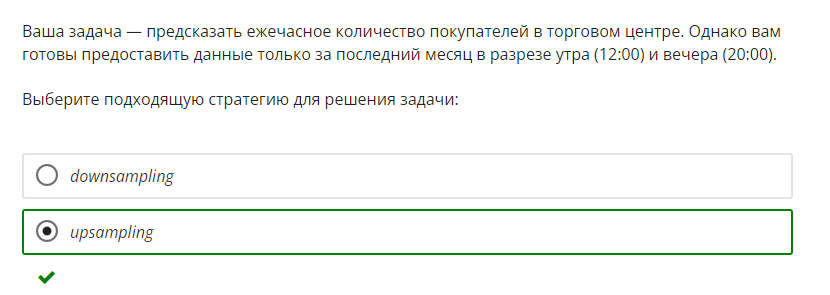

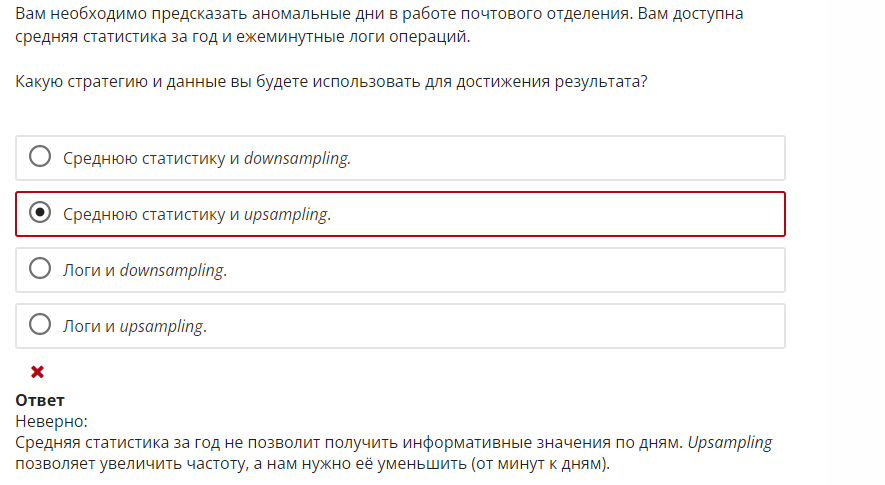

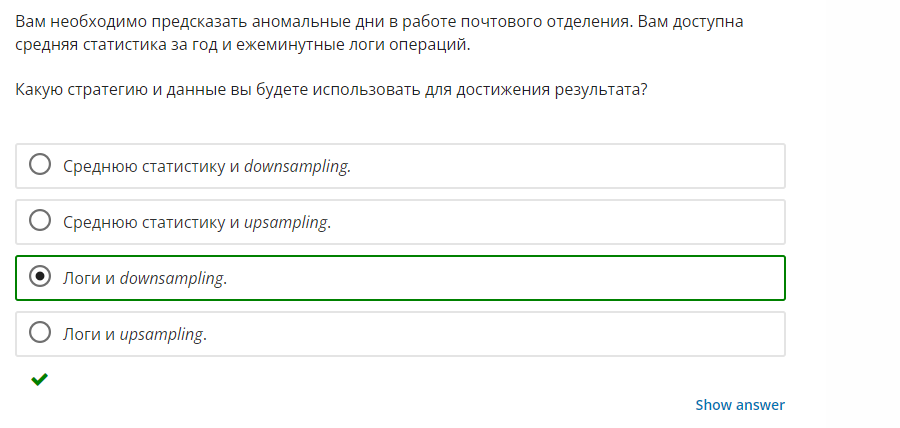

In [1]:
from warnings import filterwarnings
filterwarnings("ignore")

import pandas as pd
import statsmodels.graphics.tsaplots as sgt

data = pd.read_csv("data.csv", parse_dates=["Date"], index_col=["Date"])
data.head()

,spx
Date,
1994-01-06,467.119995
1994-01-07,469.899994
1994-01-10,475.269989
1994-01-11,474.130005
1994-01-12,474.170013


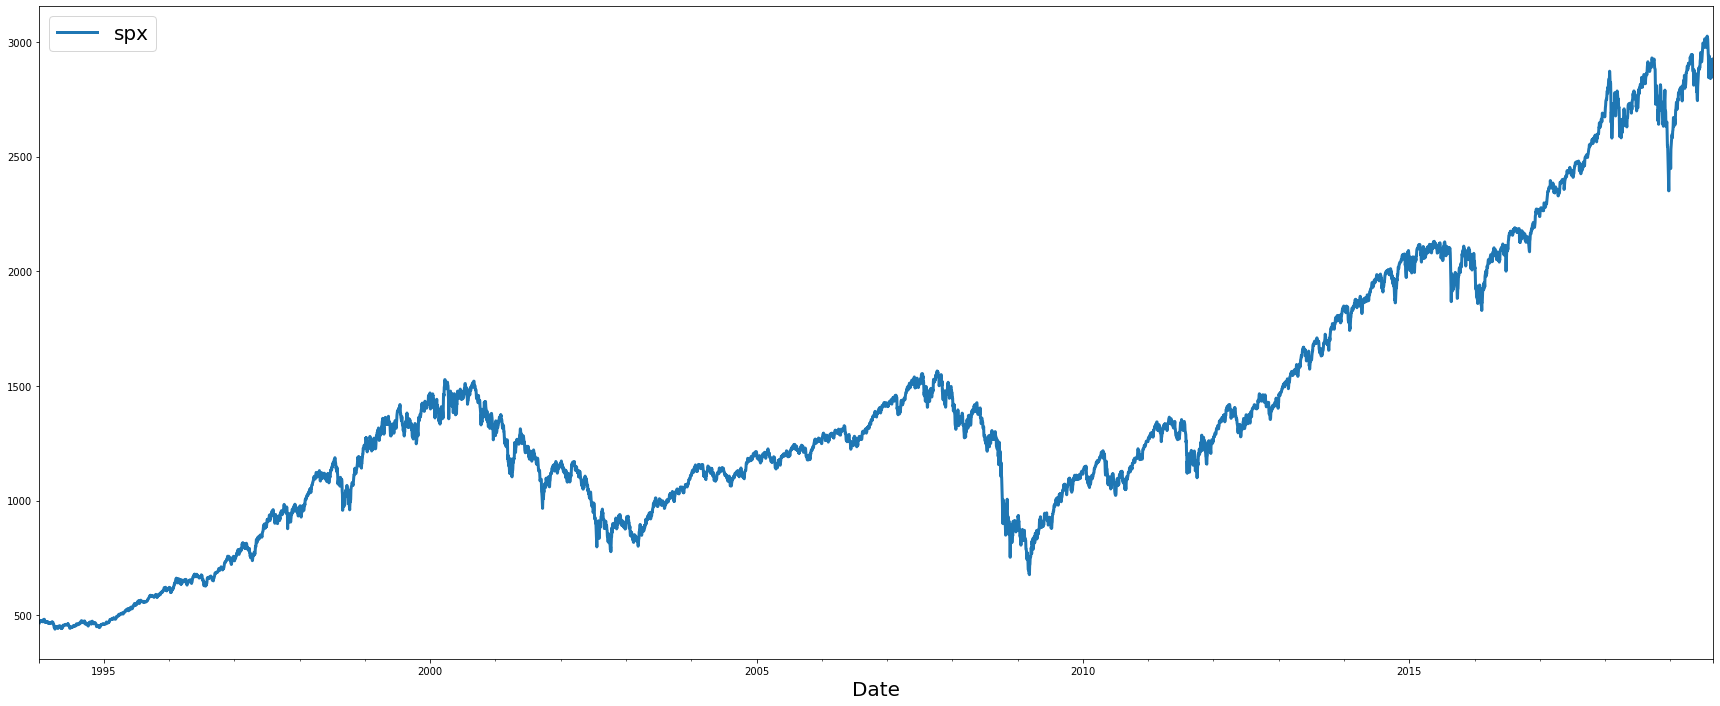

In [2]:
from matplotlib import pyplot as plt

%matplotlib inline

plt.rcParams["figure.figsize"] = 30, 12
plt.rcParams["font.size"] = 20
plt.rcParams["xtick.labelsize"] = 10
plt.rcParams["ytick.labelsize"] = 10
plt.rcParams["lines.linewidth"] = 3

data.plot()
plt.show()

In [3]:
train_df = data.loc[:"2018-12-31"]
test_df = data.loc["2019-01-01":]
train_df.shape, test_df.shape

((6518, 1), (174, 1))

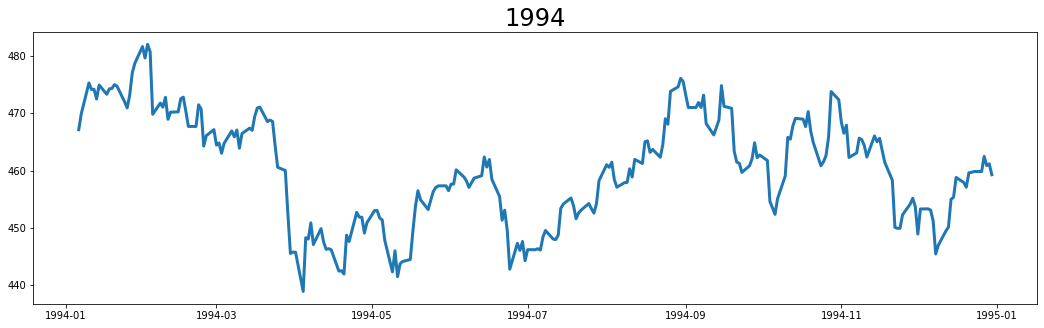

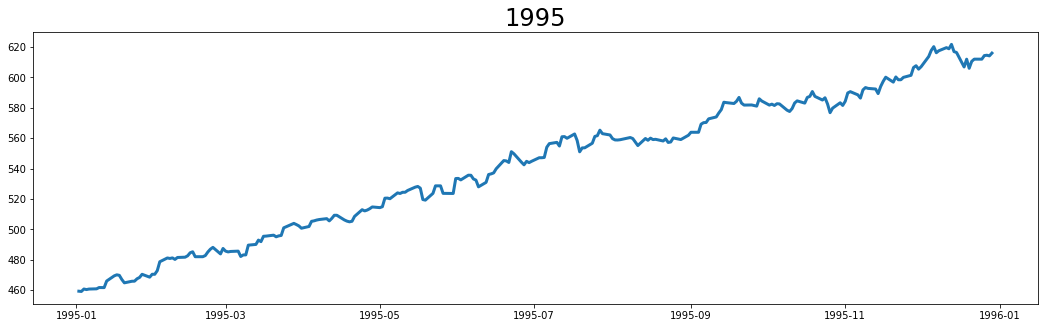

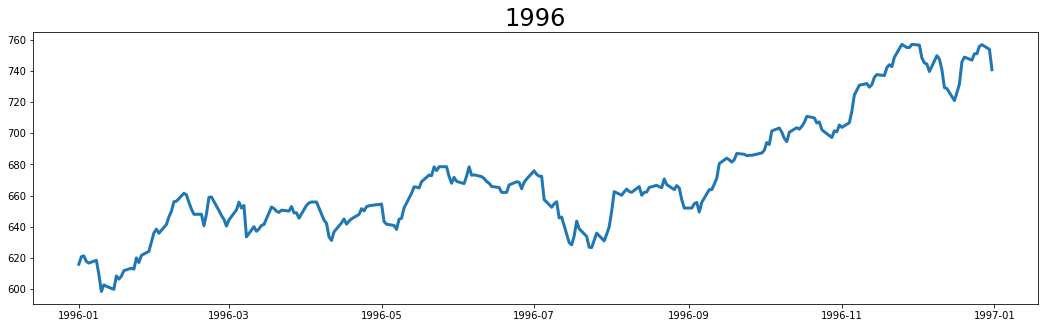

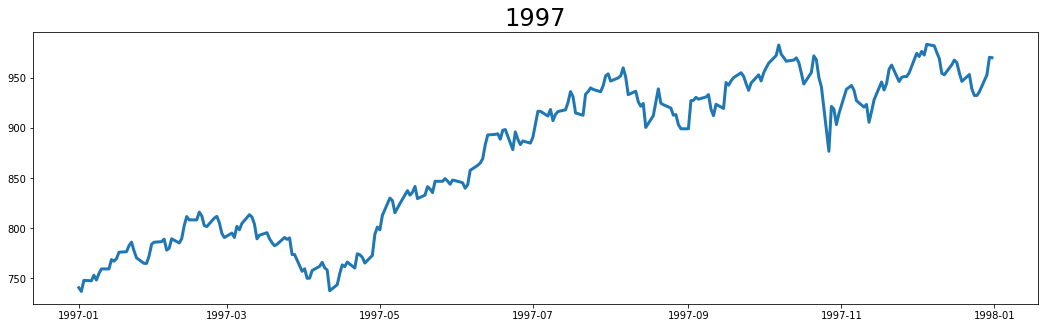

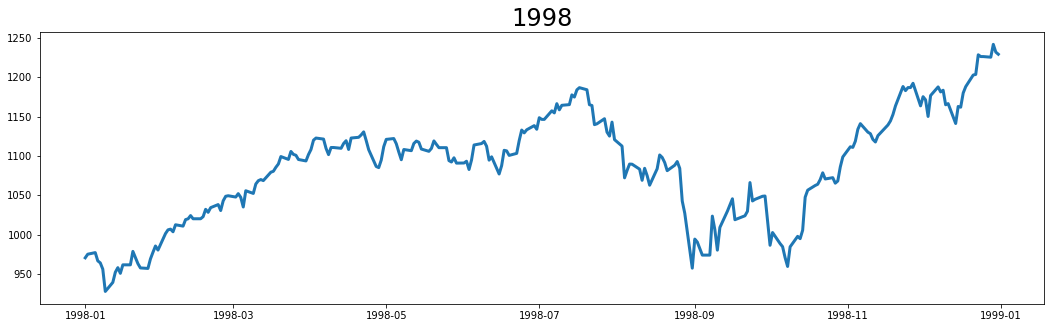

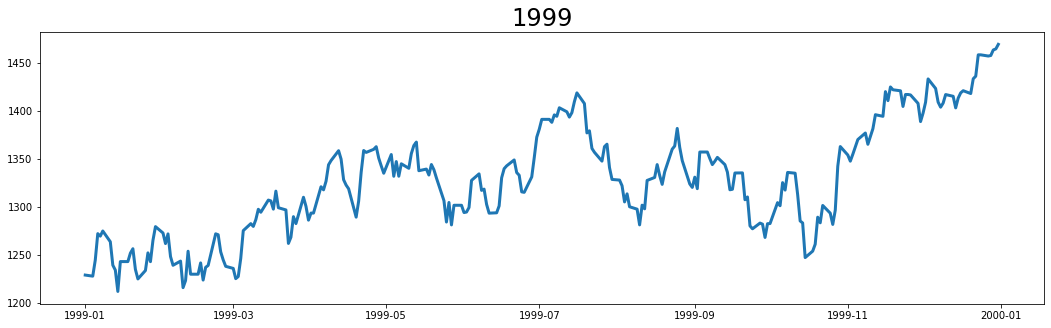

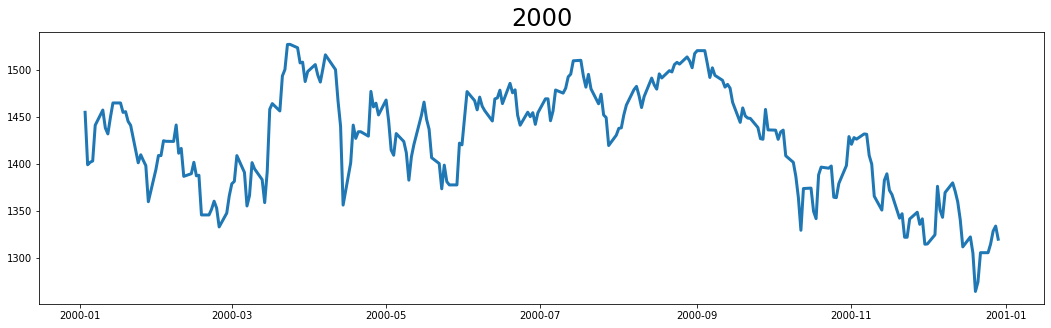

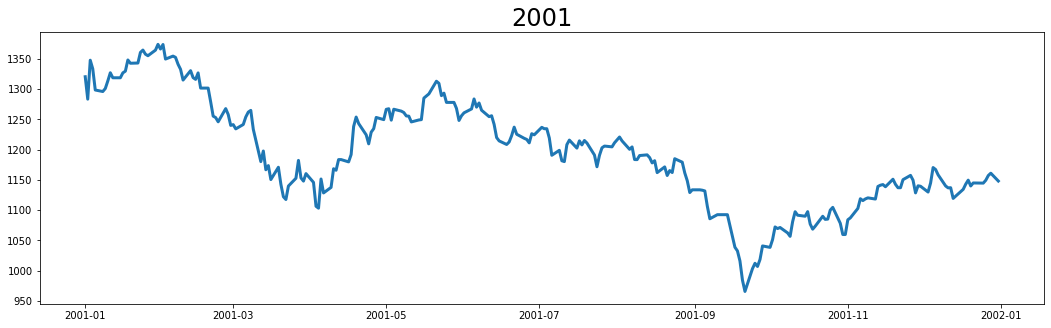

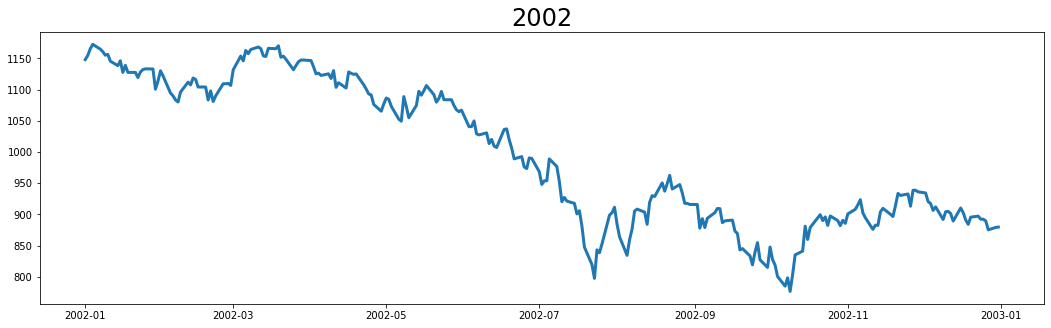

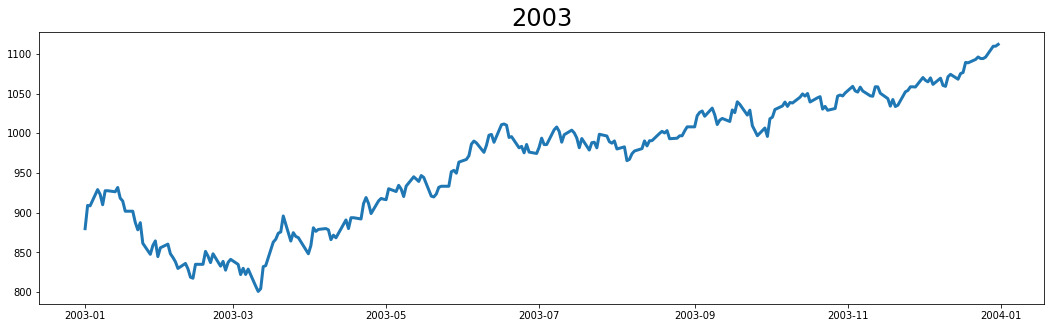

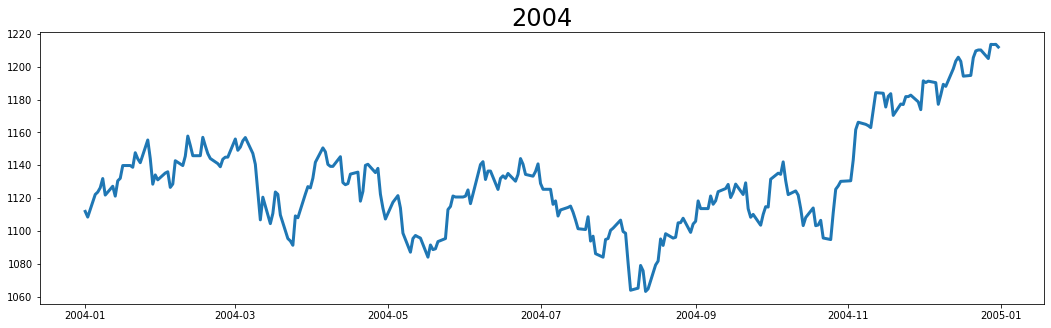

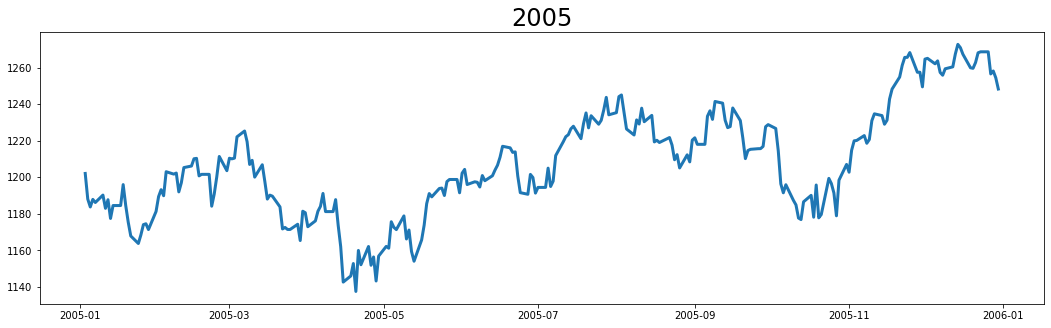

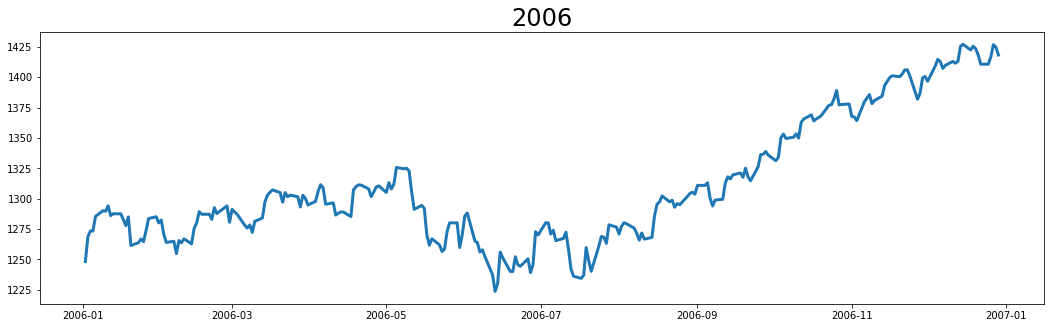

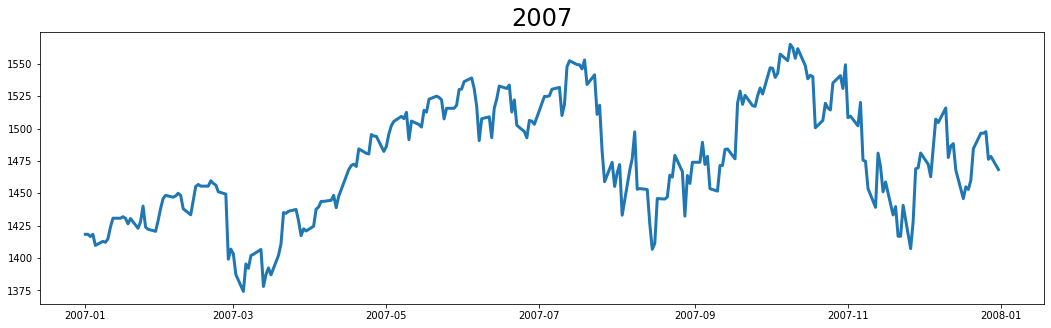

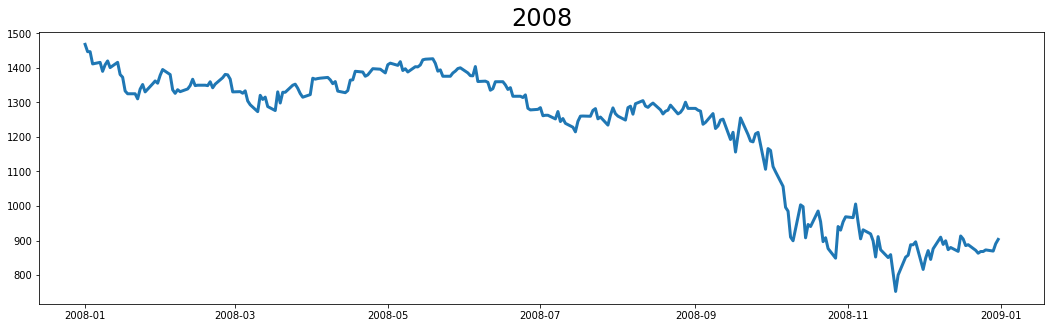

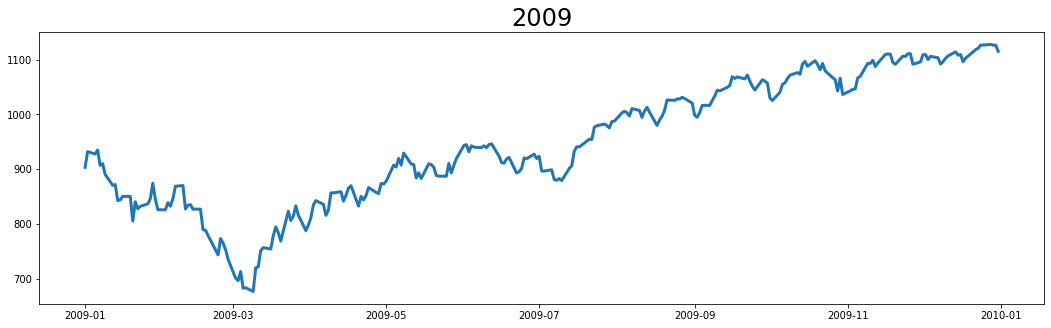

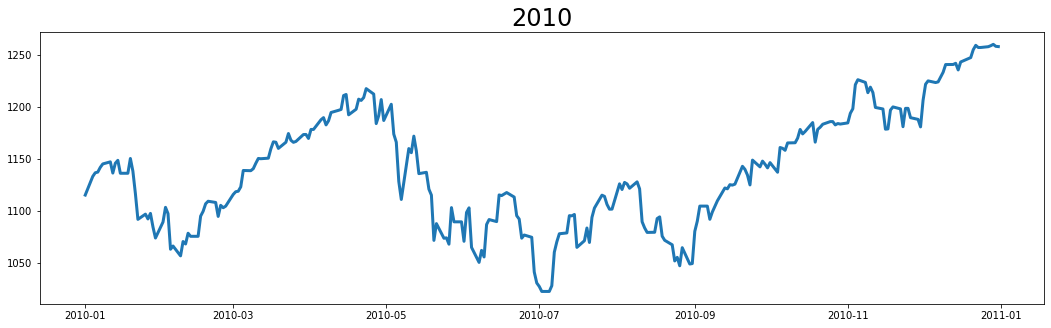

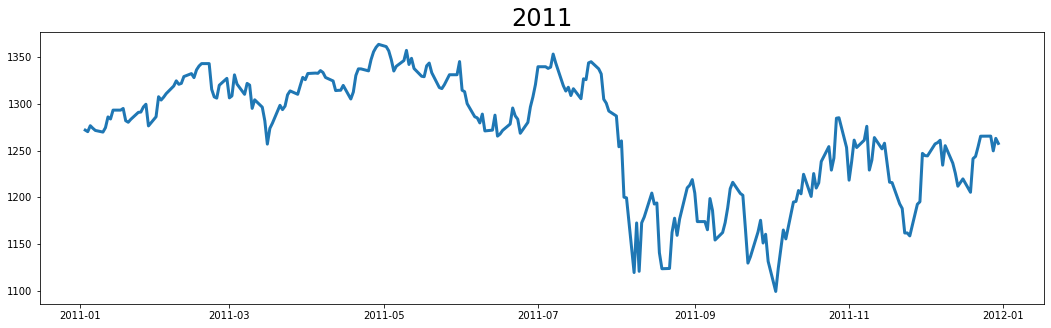

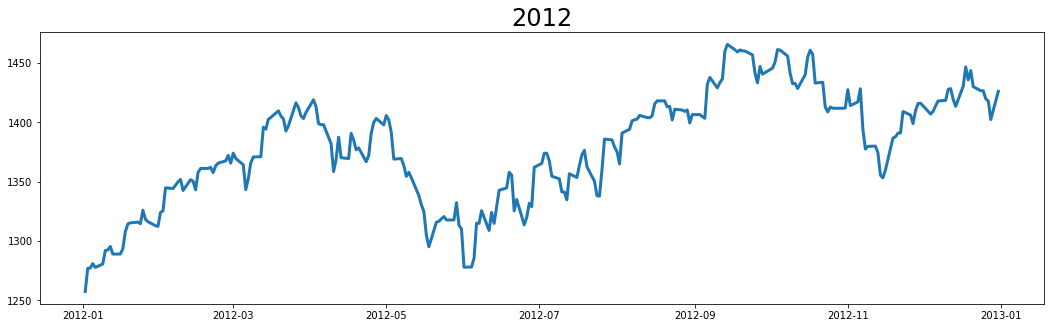

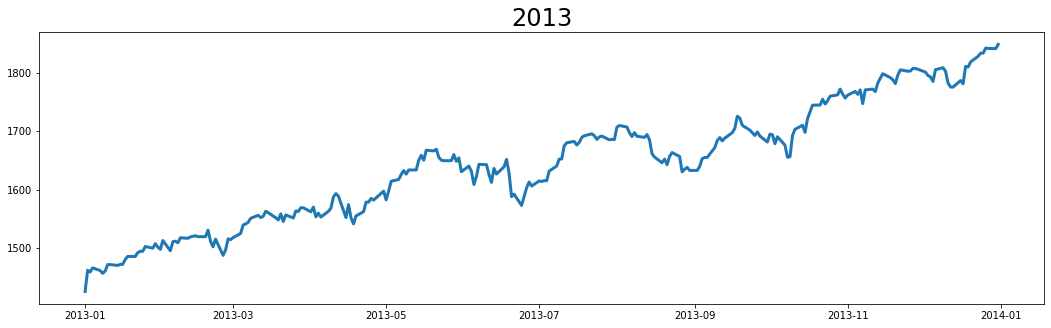

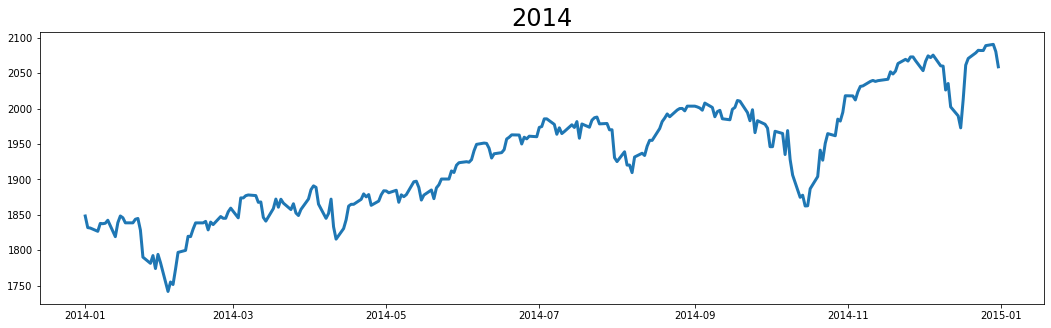

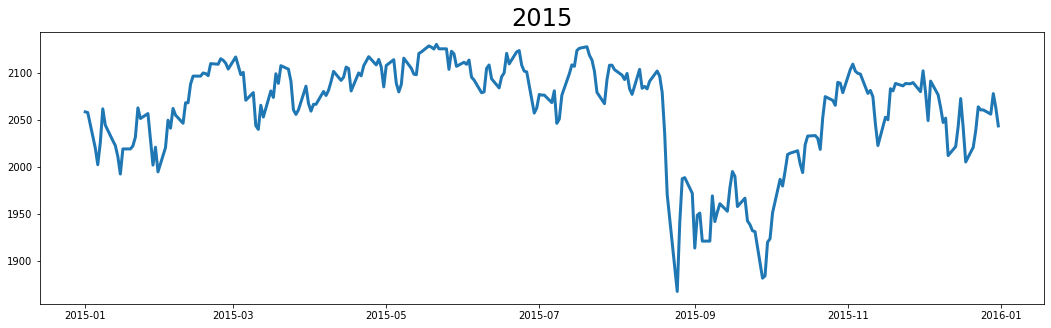

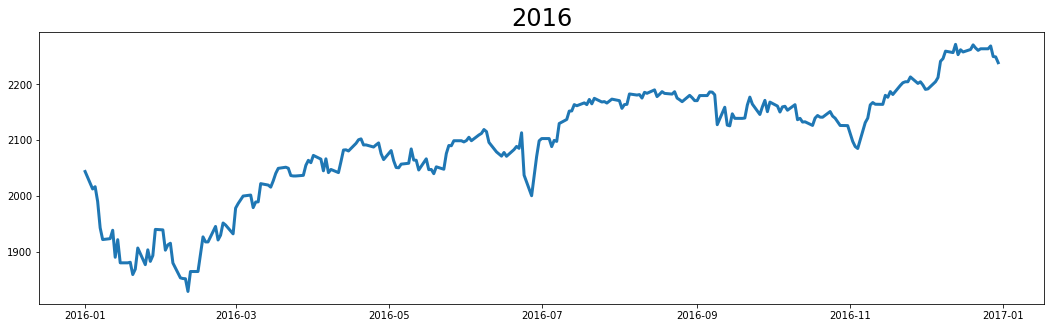

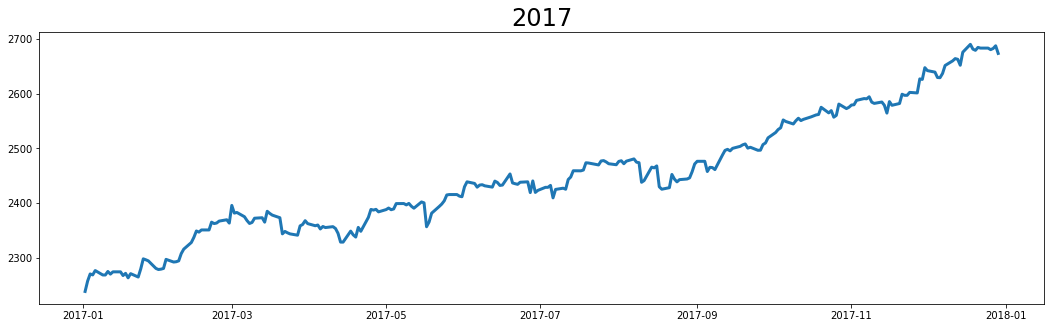

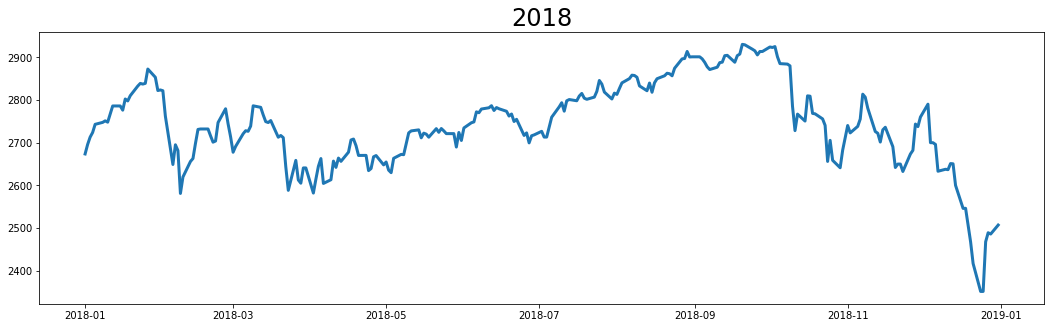

In [4]:
from matplotlib import pyplot as plt

plt.rcParams["figure.figsize"] = 18, 5

for year in set(train_df.index.year):
    plt.plot(train_df[["spx"]].loc[train_df.index.year == year])
    plt.title(str(year), size=24)
    plt.show()

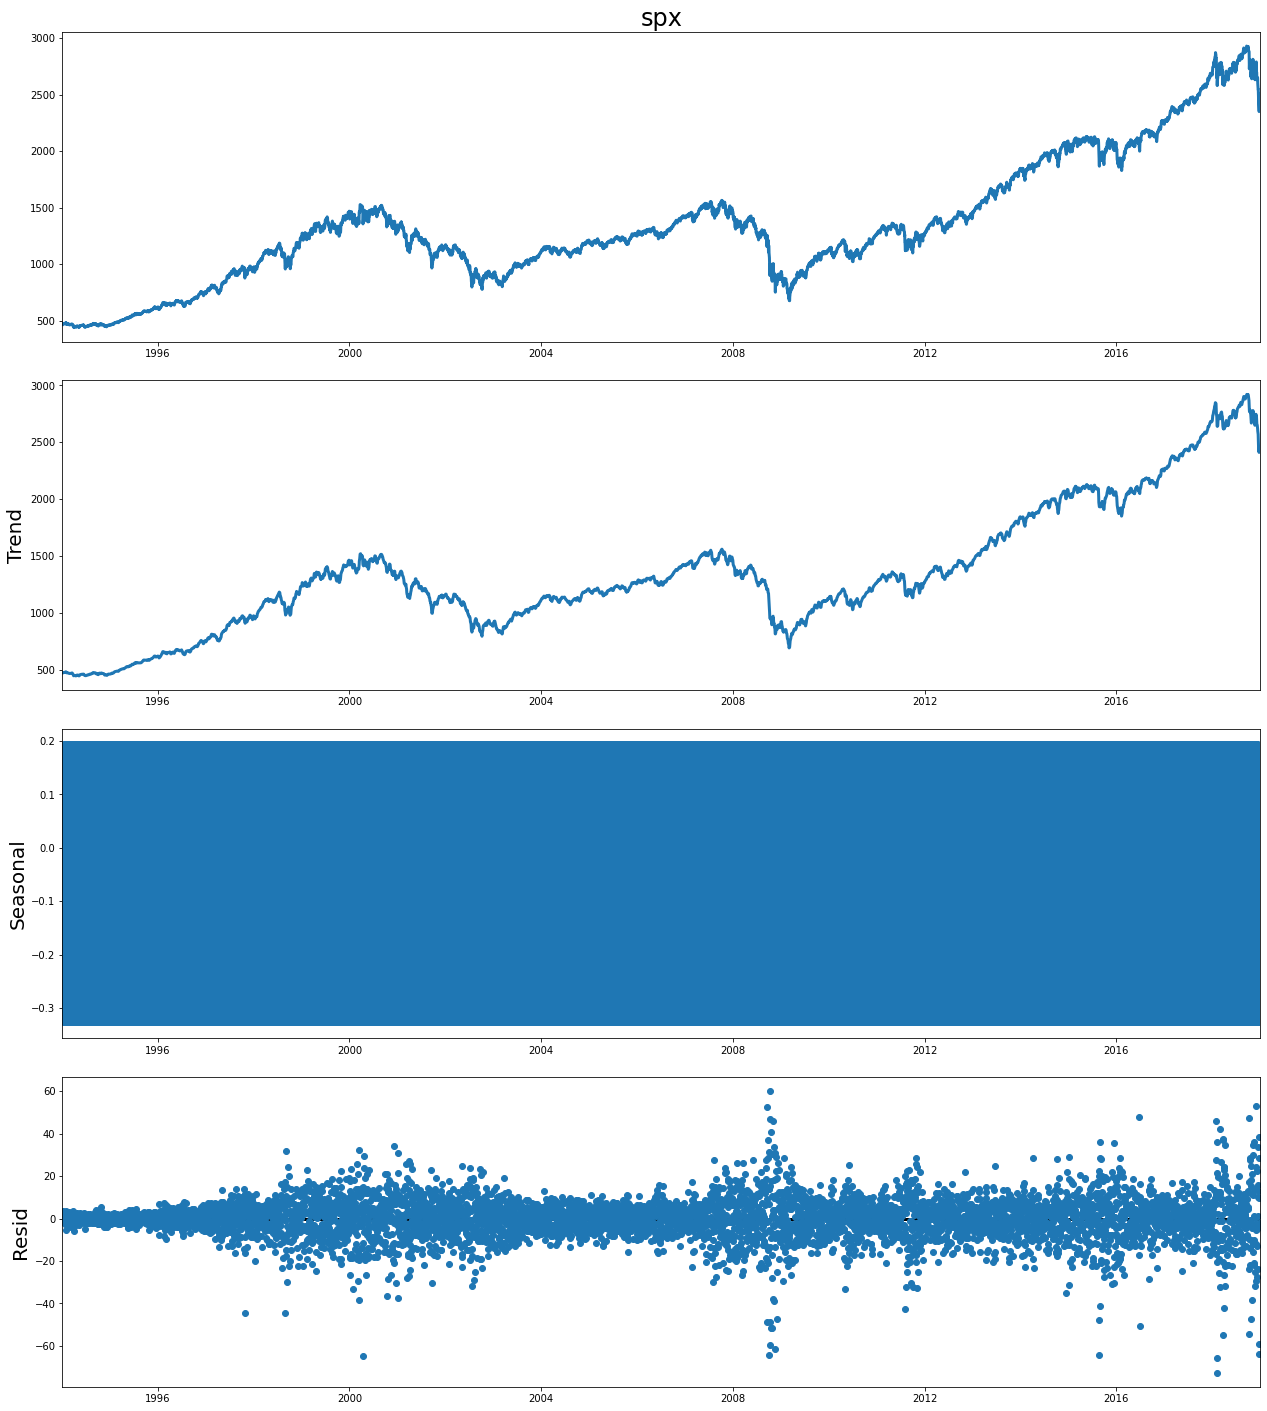

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose

plt.rcParams["figure.figsize"] = 18, 20

result = seasonal_decompose(train_df.spx)
result.plot()
plt.show()

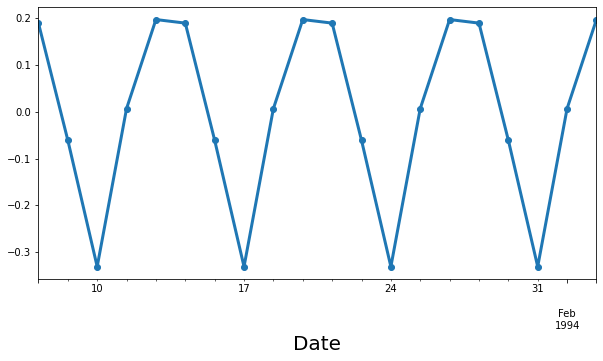

In [6]:
plt.rcParams["figure.figsize"] = 10, 5
result.seasonal[:20].plot(marker="o")
plt.show()

График четко показывает повторяющийся цикл каждые 5 периодов. Это довольно логично, поскольку наши данные — это данные о ценах на акции. Мы наблюдаем и собираем данные о ценах на акции каждый рабочий день недели. Это означает, что данные представляли собой еженедельную сезонность, а неделя была рабочей неделей (5 дней в неделю

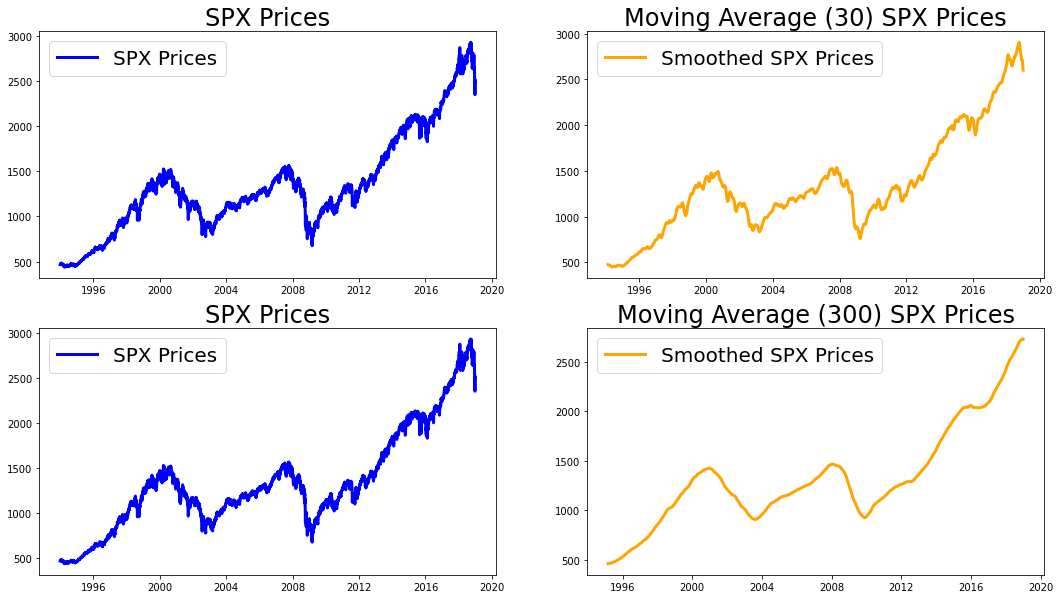

In [7]:
plt.rcParams["figure.figsize"] = 18, 10

fig, ax = plt.subplots(2, 2)

# Окно в месяц (Window = 30)
ax[0, 0].plot(train_df.spx, color="blue", label="SPX Prices")
ax[0, 0].set_title("SPX Prices", size=24)
ax[0, 0].legend()

ax[0, 1].plot(
    train_df.spx.rolling(window=30).mean(),
    color="orange",
    label="Smoothed SPX Prices",
)

ax[0, 1].set_title("Moving Average (30) SPX Prices", size=24)
ax[0, 1].legend()


# Окно в год (Window = 300)
ax[1, 0].plot(train_df.spx, color="blue", label="SPX Prices")
ax[1, 0].set_title("SPX Prices", size=24)
ax[1, 0].legend()

ax[1, 1].plot(
    train_df.spx.rolling(window=300).mean(),
    color="orange",
    label="Smoothed SPX Prices",
)

ax[1, 1].set_title("Moving Average (300) SPX Prices", size=24)
ax[1, 1].legend()

plt.show()

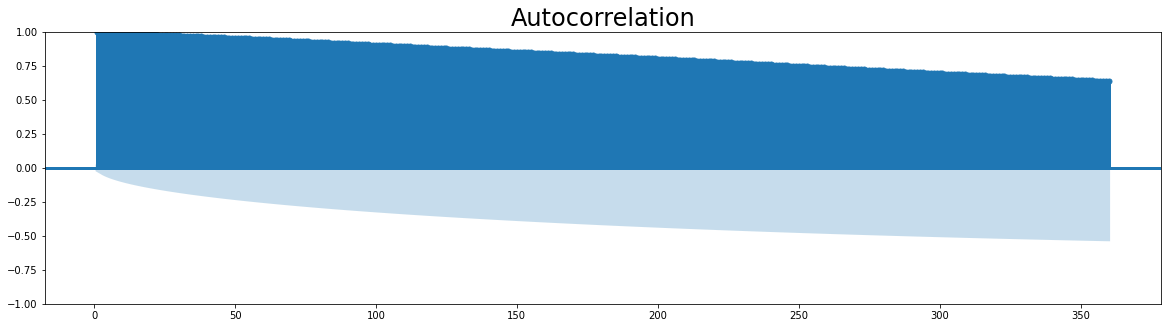

In [8]:
import statsmodels.graphics.tsaplots as sgt

plt.rcParams["figure.figsize"] = 20, 5
sgt.plot_acf(train_df.spx, lags=360, zero=False)
plt.show()

цены SPX сильно коррелированы. Корреляция сохраняется даже по прошествии года.

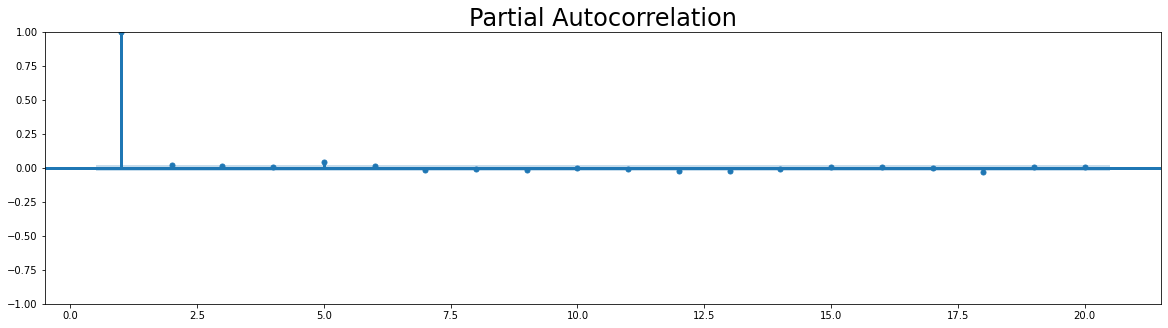

In [9]:
import statsmodels.graphics.tsaplots as sgt

plt.rcParams["figure.figsize"] = 20, 5
sgt.plot_pacf(train_df.spx, lags=20, method="ywm", zero=False)
plt.show()

Эти графики показывают, как данные коррелируют с запаздывающей версией самих себя. В отличие от того, что предлагали графики ACF, цены SPX с лагом не приносят никакой новой информации. В таких ситуация параметр p выбирается =1

In [10]:
from statsmodels.tsa.stattools import adfuller

adfuller(train_df["spx"])

(-0.3312809396965244,
 0.9209556878912157,
 10,
 6507,
 {'1%': -3.4313553606207843,
  '5%': -2.8619842833301883,
  '10%': -2.56700648865667},
 53000.32567590042)

Статистика теста больше всех критических значений, поэтому нулевую гипотезу ( H0 ) нельзя отвергнуть.

Поэтому цены SPX не являются стационарными

In [11]:
def plot_acf_pacf(series):
    plt.rcParams["figure.figsize"] = 18, 5

    fig, axes = plt.subplots(1, 2)

    sgt.plot_acf(series, ax=axes[0], lags=40)
    sgt.plot_pacf(series, ax=axes[1], lags=40, method="ywm")
    plt.show()

Дифференцирование ряда
y_newt=yt−yt−1 

where,

y_newt : Дифференцированное значение ряда  t 
yt : Фактическое значение ряда  t 
yt−1 : Фактическое значение ряда  t−1

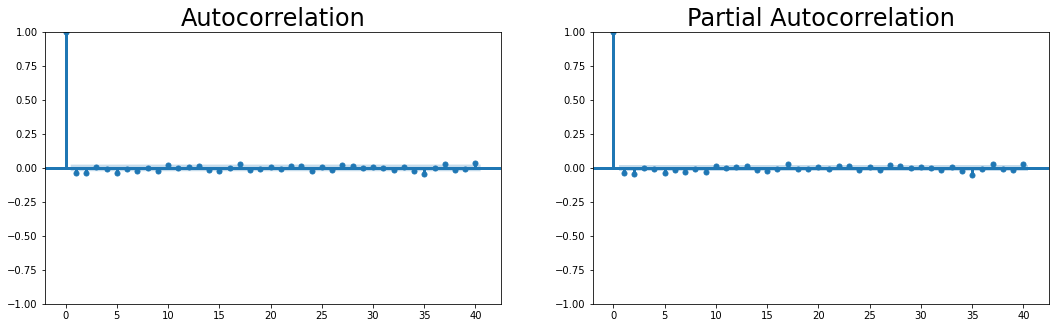

(-27.326250201731145,
 0.0,
 9,
 6507,
 {'1%': -3.4313553606207843,
  '5%': -2.8619842833301883,
  '10%': -2.56700648865667},
 52991.2781500849)

In [12]:
plot_acf_pacf(train_df["spx"].diff().dropna())
adfuller(train_df["spx"].diff().dropna())

Первые разности являются стационарными

Начнем построение модели ARIMA со следующими параметрами:

p = 1

d = 1

q = 1

Если рассматривать сезонную модель (SARMA), то в модель можно добавить следующие параметры.

m = 5 (будучи рыночным индексом, данные, скорее всего, будут иметь еженедельно повторяющиеся паттерны, как видно из визуализации)
P = 1

D = 1

Q = 1

In [13]:
from statsmodels.tsa.arima.model import ARIMA

arima_model = ARIMA(train_df["spx"].dropna(), order=(1, 1, 1))
arima_model_fit = arima_model.fit()
arima_model_fit.summary()

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    spx   No. Observations:                 6518
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -26625.675
Date:                Fri, 10 Mar 2023   AIC                          53257.350
Time:                        22:00:41   BIC                          53277.697
Sample:                    01-06-1994   HQIC                         53264.387
                         - 12-31-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7598      0.048     15.908      0.000       0.666       0.853
ma.L1         -0.8016      0.044    -18.385      0.000      -0.887      -0.716
sigma2       207.1124      1.766    117.304      0.000     203.652     210.573
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):             12081.79
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               1.93   Skew:                            -0.62
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [14]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(train_df["spx"].dropna(), order=(1, 1, 1))
model_fit = model.fit()
model_fit.summary()

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    spx   No. Observations:                 6518
Model:               SARIMAX(1, 1, 1)   Log Likelihood              -26625.675
Date:                Fri, 10 Mar 2023   AIC                          53257.350
Time:                        22:00:56   BIC                          53277.697
Sample:                    01-06-1994   HQIC                         53264.387
                         - 12-31-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7598      0.048     15.908      0.000       0.666       0.853
ma.L1         -0.8016      0.044    -18.385      0.000      -0.887      -0.716
sigma2       207.1124      1.766    117.304      0.000     203.652     210.573
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):             12081.79
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               1.93   Skew:                            -0.62
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Второй столбец раздела I содержит некоторые полезные показатели, которые используются для сравнения различных моделей ARIMA. Как правило, модель с более высоким логарифмическим правдоподобием или более низким IC (AIC, BIC или HQIC) лучше, и наоборот.

In [15]:
seas_model = SARIMAX(
    train_df["spx"].dropna(), order=(1, 1, 2), seasonal_order=(1, 1, 2, 5)
)

seas_model_fit = seas_model.fit()
seas_model_fit.summary()

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                               spx   No. Observations:                 6518
Model:             SARIMAX(1, 1, 2)x(1, 1, 2, 5)   Log Likelihood              -26617.829
Date:                           Fri, 10 Mar 2023   AIC                          53249.657
Time:                                   22:02:04   BIC                          53297.127
Sample:                               01-06-1994   HQIC                         53266.074
                                    - 12-31-2018                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1565      0.169      0.924      0.355      -0.175       0.488
ma.L1         -0.1993      0.169     -1.183      0.237      -0.530       0.131
ma.L2         -0.0333      0.011     -2.898      0.004      -0.056      -0.011
ar.S.L5       -0.7732      0.081     -9.558      0.000      -0.932      -0.615
ma.S.L5       -0.2578      0.085     -3.031      0.002      -0.425      -0.091
ma.S.L10      -0.7414      0.086     -8.656      0.000      -0.909      -0.574
sigma2       206.7707      1.991    103.839      0.000     202.868     210.674
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             11680.21
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.91   Skew:                            -0.57
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

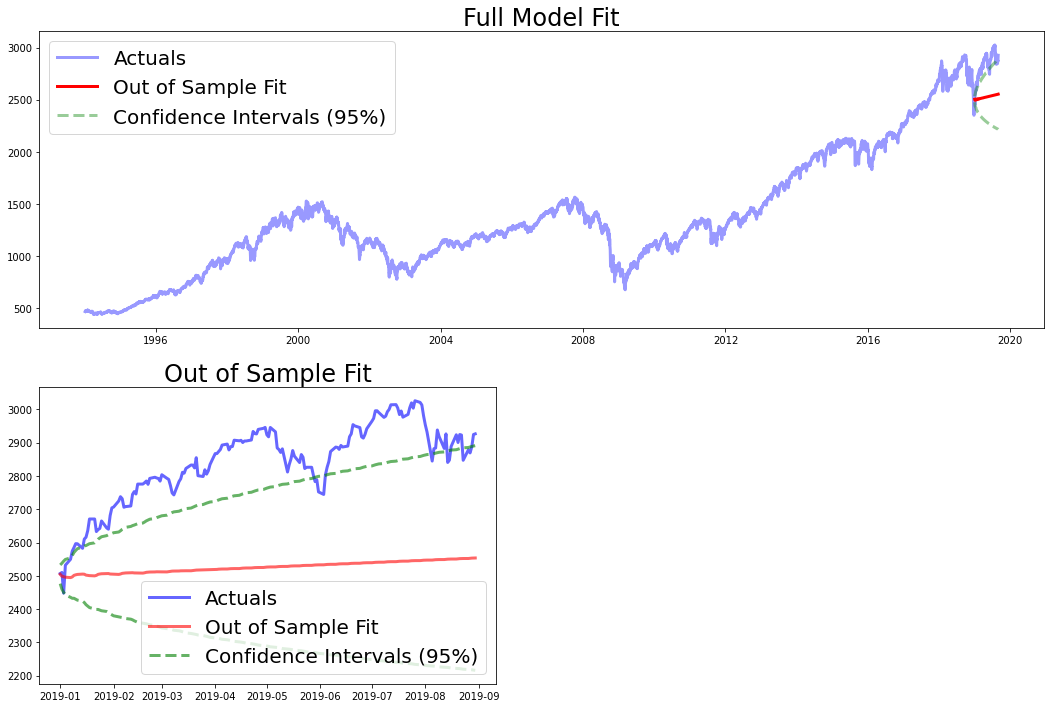

In [16]:
pred_df = pd.DataFrame(index=data.index)

pred_df["model_preds"] = seas_model_fit.predict(
    start=test_df.index[0], end=test_df.index[-1]
)


pred_df["spx"] = data["spx"]

forecast = seas_model_fit.get_forecast(len(test_df.index))
forecast_df = forecast.conf_int(alpha=0.05)  # Confidence level of 95%

pred_df.at[test_df.index, "model_preds_lower"] = forecast_df["lower spx"]
pred_df.at[test_df.index, "model_preds_upper"] = forecast_df["upper spx"]


plt.rcParams["figure.figsize"] = 18, 12

plt.subplot(2, 1, 1)
plt.plot(pred_df["spx"], color="blue", label="Actuals", alpha=0.4)

plt.plot(
    pred_df.loc[test_df.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.4,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.4,
)

plt.title("Full Model Fit", size=24)
plt.legend()

plt.subplot(2, 2, 3)

plt.plot(
    pred_df.loc[test_df.index]["spx"], color="blue", label="Actuals", alpha=0.6
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.6,
)

plt.title("Out of Sample Fit", size=24)
plt.legend()

plt.show()

In [17]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 21.6 MB/s eta 0:00:00


In [18]:
import pmdarima as pm

smodel = pm.auto_arima(
    train_df,
    start_p=1,
    d=1,
    start_q=1,
    max_p=3,
    max_q=3,
    D=1,
    start_P=0,
    m=5,
    test="adf",
    error_action="ignore",
    trace=True,
)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[5]             : AIC=inf, Time=13.20 sec
 ARIMA(0,1,0)(0,1,0)[5]             : AIC=57943.325, Time=0.48 sec
 ARIMA(1,1,0)(1,1,0)[5]             : AIC=55834.625, Time=1.42 sec
 ARIMA(0,1,1)(0,1,1)[5]             : AIC=inf, Time=8.07 sec
 ARIMA(1,1,0)(0,1,0)[5]             : AIC=57939.123, Time=0.41 sec
 ARIMA(1,1,0)(2,1,0)[5]             : AIC=55138.362, Time=2.58 sec
 ARIMA(1,1,0)(2,1,1)[5]             : AIC=inf, Time=24.16 sec
 ARIMA(1,1,0)(1,1,1)[5]             : AIC=inf, Time=12.40 sec
 ARIMA(0,1,0)(2,1,0)[5]             : AIC=55142.946, Time=2.05 sec
 ARIMA(2,1,0)(2,1,0)[5]             : AIC=55124.504, Time=3.33 sec
 ARIMA(2,1,0)(1,1,0)[5]             : AIC=55827.531, Time=2.41 sec
 ARIMA(2,1,0)(2,1,1)[5]             : AIC=inf, Time=34.06 sec
 ARIMA(2,1,0)(1,1,1)[5]             : AIC=inf, Time=18.06 sec
 ARIMA(3,1,0)(2,1,0)[5]             : AIC=55125.927, Time=5.45 sec
 ARIMA(2,1,1)(2,1,0)[5]             : AIC=55141.92

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 6518
Model:             SARIMAX(2, 1, 0)x(2, 1, 0, 5)   Log Likelihood              -27557.252
Date:                           Fri, 10 Mar 2023   AIC                          55124.504
Time:                                   22:05:27   BIC                          55158.411
Sample:                               01-06-1994   HQIC                         55136.230
                                    - 12-31-2018                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0335      0.008     -4.447      0.000      -0.048      -0.019
ar.L2         -0.0494      0.007     -7.204      0.000      -0.063      -0.036
ar.S.L5       -0.6999      0.007    -99.802      0.000      -0.714      -0.686
ar.S.L10      -0.3228      0.007    -43.233      0.000      -0.337      -0.308
sigma2       277.3268      2.423    114.438      0.000     272.577     282.077
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             11066.86
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               1.98   Skew:                             0.15
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Downsampling / Upsampling / Интерполяция

In [19]:
print(data.shape)
data[(data.index > "2005-01-06") & (data.index < "2005-02-10")].head()

(6692, 1)


,spx
Date,
2005-01-07,1186.189941
2005-01-10,1190.250000
2005-01-11,1182.989990
2005-01-12,1187.699951
2005-01-13,1177.449951


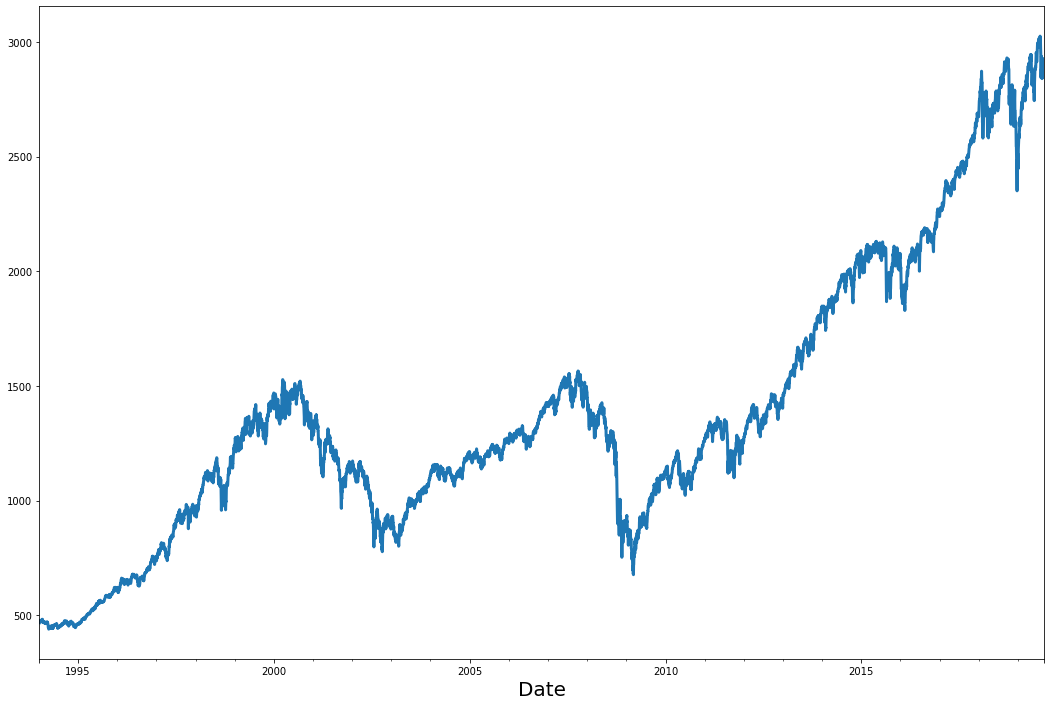

In [20]:
data.spx.plot()
plt.show()

(1339, 1)


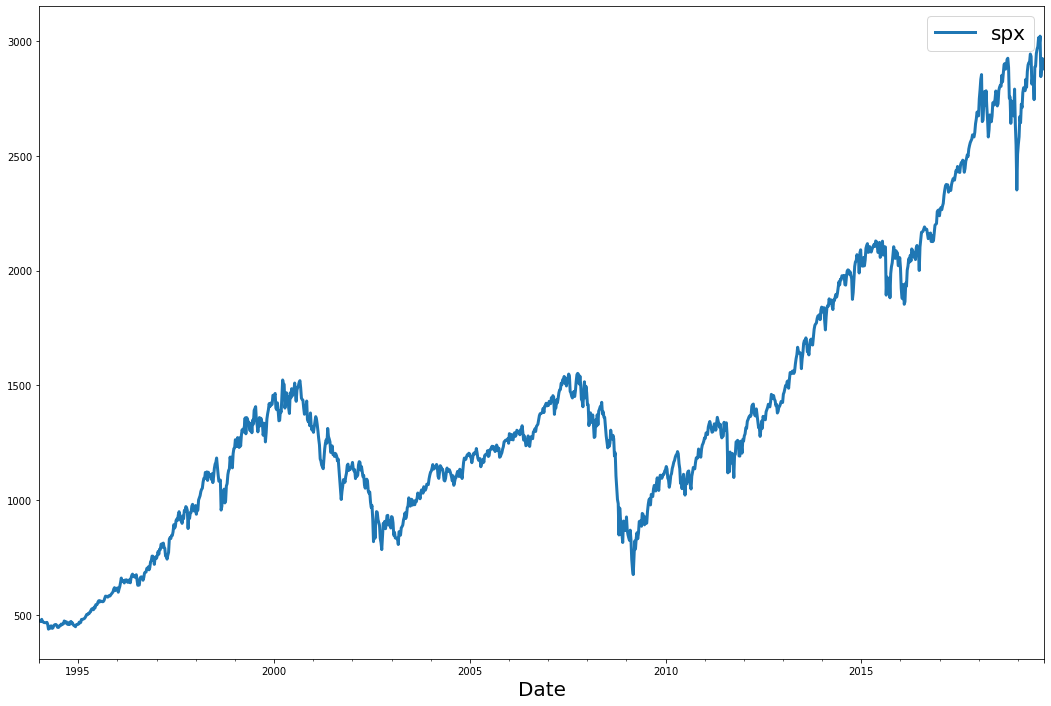

In [21]:
interpolated_data = pd.DataFrame(
    data.spx.resample("w-MON").interpolate(), columns=["spx"]
)

print(interpolated_data.shape)
interpolated_data.plot()
plt.show()

In [22]:
interpolated_data.head()

,spx
Date,
1994-01-10,475.269989
1994-01-17,473.299988
1994-01-24,471.970001
1994-01-31,481.609985
1994-02-07,471.760010


In [23]:
train_df = interpolated_data.loc[:"2018-12-31"]
test_df = interpolated_data.loc["2019-01-01":]
train_df.shape, test_df.shape

((1304, 1), (35, 1))

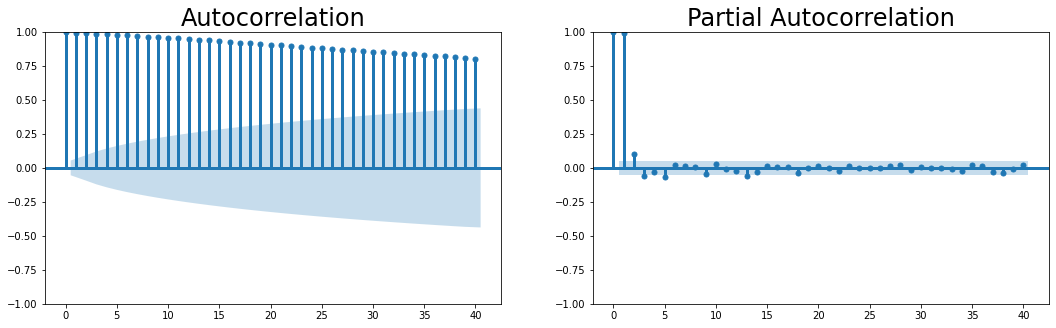

(-0.2607657143116782,
 0.9308801996019748,
 10,
 1293,
 {'1%': -3.4354175403897727,
  '5%': -2.8637778952086848,
  '10%': -2.5679614713589562},
 12512.497637173248)

In [24]:
plot_acf_pacf(train_df["spx"].dropna())
adfuller(train_df["spx"].dropna())

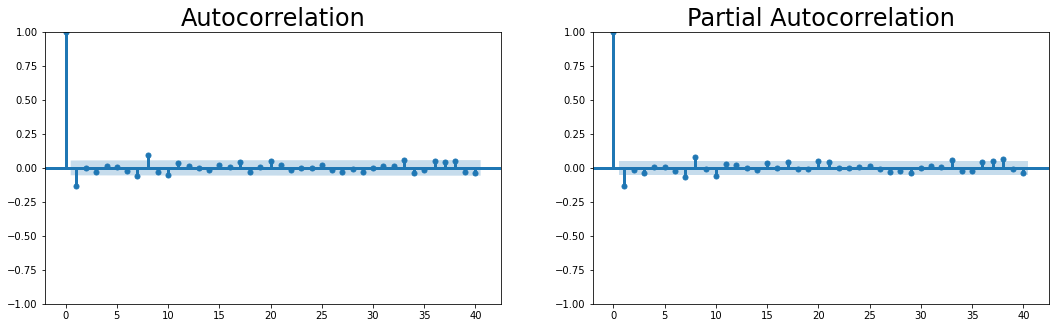

(-11.946377875600588,
 4.420358877552662e-22,
 9,
 1293,
 {'1%': -3.4354175403897727,
  '5%': -2.8637778952086848,
  '10%': -2.5679614713589562},
 12501.713967337682)

In [25]:
plot_acf_pacf(train_df["spx"].diff().dropna())
adfuller(train_df["spx"].diff().dropna())

In [26]:
from statsmodels.tsa.arima.model import ARIMA
from matplotlib import pyplot as plt

arima_model = ARIMA(train_df["spx"].dropna(), order=(1, 1, 1))
arima_model_fit = arima_model.fit()
arima_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    spx   No. Observations:                 1304
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -6359.035
Date:                Fri, 10 Mar 2023   AIC                          12724.070
Time:                        22:05:55   BIC                          12739.587
Sample:                    01-10-1994   HQIC                         12729.891
                         - 12-31-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0215      0.137      0.157      0.875      -0.247       0.290
ma.L1         -0.1545      0.132     -1.173      0.241      -0.413       0.104
sigma2      1015.0734     20.021     50.701      0.000     975.833    1054.314
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              2373.55
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               2.31   Skew:                            -1.14
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [27]:
pred_df = pd.DataFrame(index=interpolated_data.index)

pred_df["model_preds"] = arima_model_fit.predict(
    start=test_df.index[0], end=test_df.index[-1]
)


pred_df["spx"] = data["spx"]

forecast = arima_model_fit.get_forecast(len(test_df.index))
forecast_df = forecast.conf_int(alpha=0.05)  # Confidence level of 95%

pred_df.at[test_df.index, "model_preds_lower"] = forecast_df["lower spx"]
pred_df.at[test_df.index, "model_preds_upper"] = forecast_df["upper spx"]

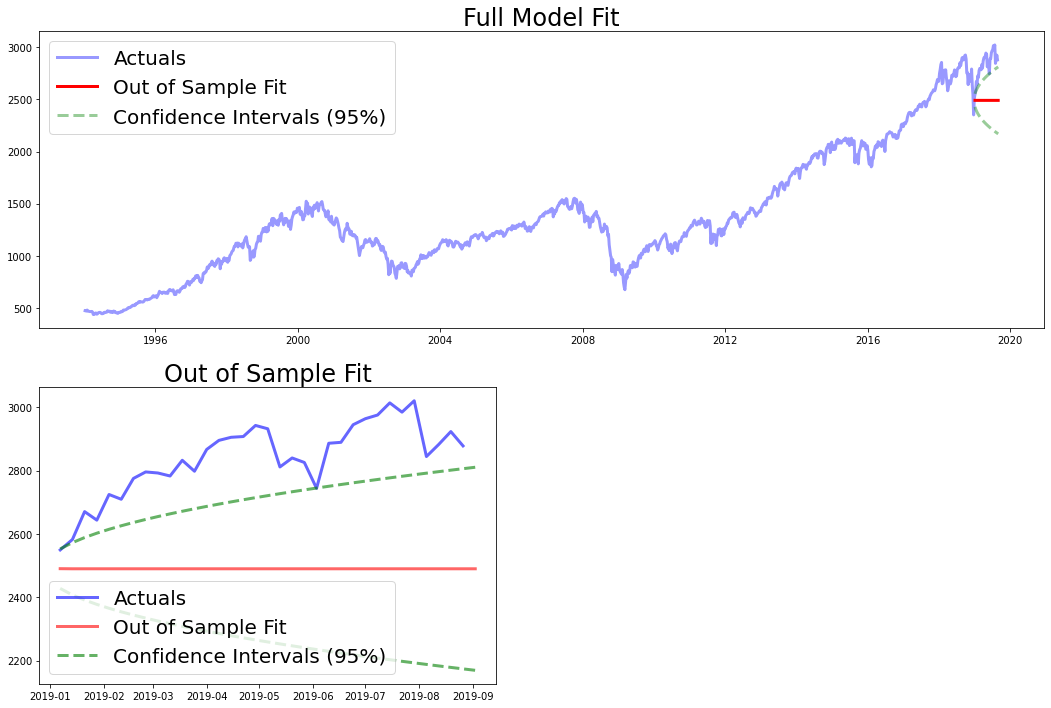

In [28]:
plt.rcParams["figure.figsize"] = 18, 12

plt.subplot(2, 1, 1)
plt.plot(pred_df["spx"], color="blue", label="Actuals", alpha=0.4)

plt.plot(
    pred_df.loc[test_df.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.4,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.4,
)

plt.title("Full Model Fit", size=24)
plt.legend()

plt.subplot(2, 2, 3)

plt.plot(
    pred_df.loc[test_df.index]["spx"], color="blue", label="Actuals", alpha=0.6
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.6,
)

plt.title("Out of Sample Fit", size=24)
plt.legend()

plt.show()

Мы уже изучили основные свойства временных рядов, но у них есть ещё одна интересная и нередко встречающаяся особенность. Обратите внимание на график квартального дохода компании Wal-Mart. Видно, что присутствует тренд. Но какую ещё особенность вы видите?

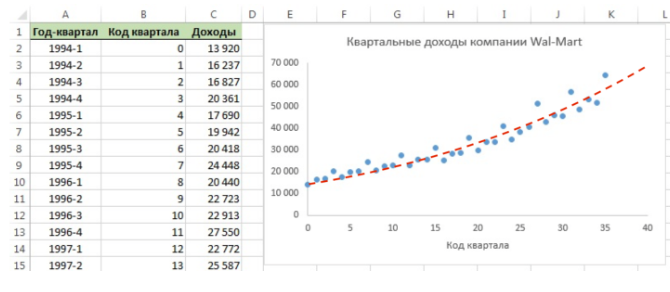

Прежде чем перейти к обсуждению, вспомним, что такое дисперсия.

Дисперсия — это статистический показатель, показывающий меру разброса данных вокруг среднего значения.

Если мы проведём на графике усреднённую прямую (красный пунктир), будет заметно, что ближе к 1997 году точки имеют больший разброс, чем в начале, то есть дисперсия данных изменчива во времени.

Подобная неоднородность наблюдений, выражающаяся в неодинаковой дисперсии, называется гетероскедастичностью.

Такой характер дисперсии можно часто встретить во временных рядах из финансовой сферы, поскольку они более подвержены гетероскедастичности.

Отсутствие гетероскедастичности называется гомоскедастичностью.

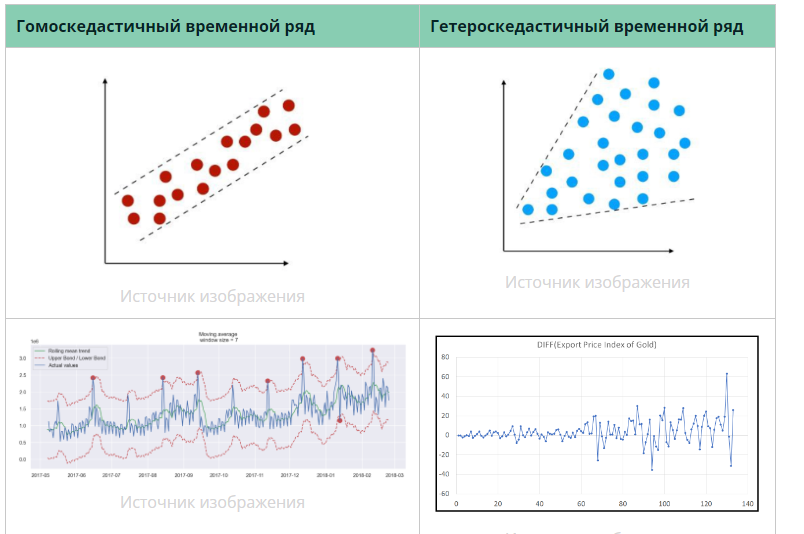

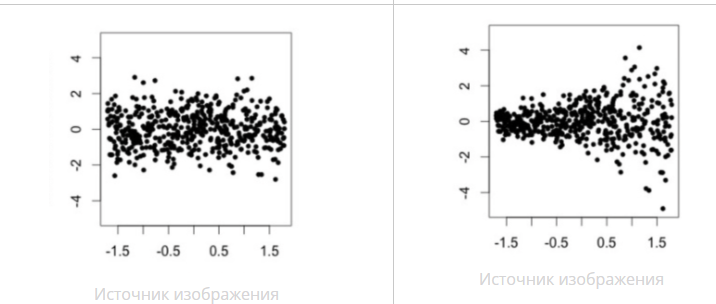

Изученные нами модели помогают учесть тренд и сезонность. Но что насчёт дисперсии? Обычно, если временной ряд обладает гетероскедастичностью, такие модели не способны уловить изменение дисперсии во времени, и их предсказания выглядят примерно так:

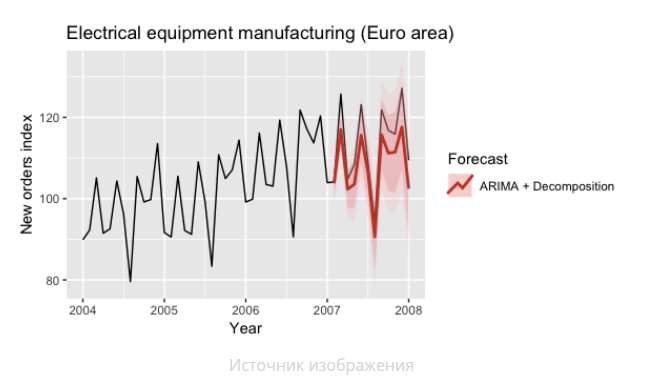

Видно, что в предсказании мы не учли разброс — прогноз хочется «вытянуть» вверх, таким образом увеличивая дисперсию. Такая проблема часто возникает в волатильных временных рядах. Понятие волатильности также относится к финансовым временным рядам и является одним из самых важных финансовых показателей и понятий в управлении финансовыми рисками.

Волатильность представляет собой меру риска использования финансового инструмента за заданный промежуток времени. Иными словами, волатильность показывает меру изменчивости и часто измеряется в процентах или долях. Предсказание волатильности, например, позволяет инвесторам определить риск приобретения финансового инструмента.

Для таких данных с непостоянной дисперсией был разработан ещё один класс моделей — семейство моделей авторегрессионной условной гетероскедастичности, или ARCH (Autoregressive Conditional Heteroscedastic Model).

ARCH И GARCH

Давайте сначала разберёмся, как устроена модель ARCH, а затем поговорим о том, как правильно её применять.

Ниже представлен график ошибок предсказания некоторого временного ряда. Что с ним не так?



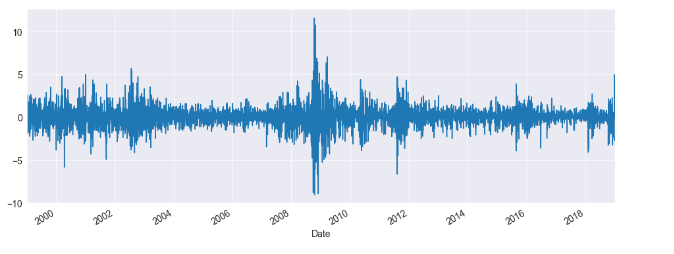

В хорошей модели, учитывающей все зависимости, в остатках должен получиться белый шум. Однако белый шум должен иметь одинаковое распределение на всех участках временного ряда, а значит, иметь одинаковые математическое ожидание и дисперсию.

Если на графике выше с математическим ожиданием всё в порядке (среднее значение в нуле), то к дисперсии есть вопросы, так как видно, что она различна на разных промежутках (разброс в разные годы отличен).

Ранее мы уже говорили, что модели семейства ARMA способны предсказывать тренд и сезонность, но, к сожалению, не изменчивость дисперсии. Модель ARCH была разработана лауреатом Нобелевской премии по экономике Робертом Энглом в 1982 г. для решения подобных проблем. В ней используется зависимая от времени условная дисперсия, которая выражается через квадрат предыдущих значений.

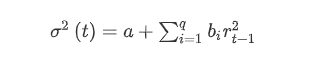

Здесь  q— количество слагаемых, которые влияют на текущее значение, а b — весовые коэффициенты, которые влияют на степень значимости предыдущих изменений дисперсии (r). То есть волатильность моделируется в виде суммы константы (a — базовая волатильность, константа) и линейной функции абсолютных значений изменения нескольких последних цен.

Чуть позднее другой учёный, Тим Боллерслерв, предложил обобщённую концепцию модели ARCH — GARCH (Generalized Autoregressive Conditional Heteroscedastic Model). Модель предполагала, что на изменчивость дисперсии влияют не только предыдущие изменения показателей, но и предыдущие оценки дисперсии (значение дисперсии).

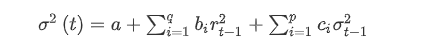

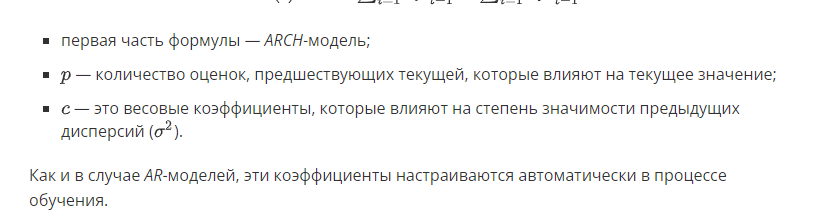

ARCH и GARCH — наиболее популярные модели, используемые при прогнозе волатильности. Существуют и их модернизации, такие как A-GARCH, E-GARCH и многие другие. В будущем, если вам придётся тесно работать с финансовыми временными рядами, вы сможете самостоятельно познакомиться с этими моделями.

КОГДА ПРИМЕНЯТЬ ARCH И GARCH?

Когда ряд похож на белый шум, но при этом в нём присутствует гетероскедастичность.
Чтобы определить, является ли ряд гетероскедастичным (с меняющейся дисперсией), можно отобразить его квадраты на графике и понаблюдать за поведением дисперсии.

Когда после применения AR-модели остатки (ошибки модели) тоже являются гетероскедастичными. В этом случае вы также можете прогнозировать дисперсию ошибок и использовать её в итоговом предсказании. Для этого необходимо суммировать результаты AR-модели с результатами ARCH.

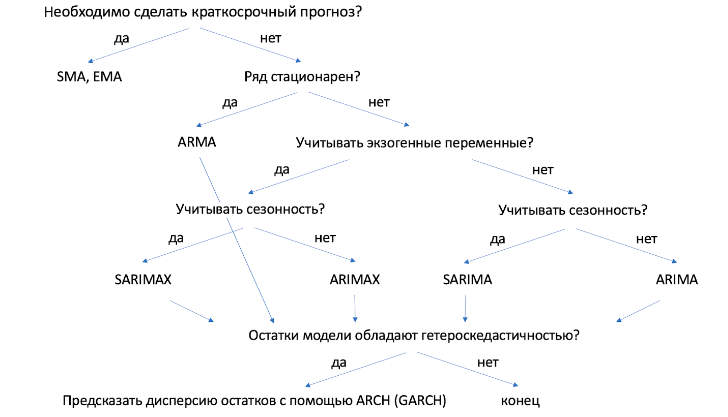

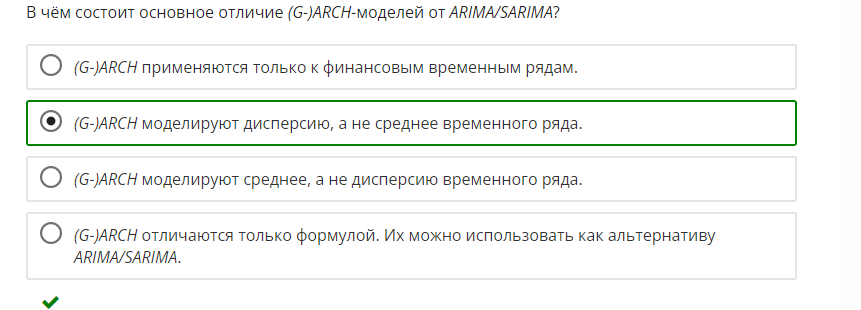

https://www.youtube.com/watch?v=Li95a2biFCU

https://medium.com/@ranjithkumar.rocking/time-series-model-s-arch-and-garch-2781a982b448

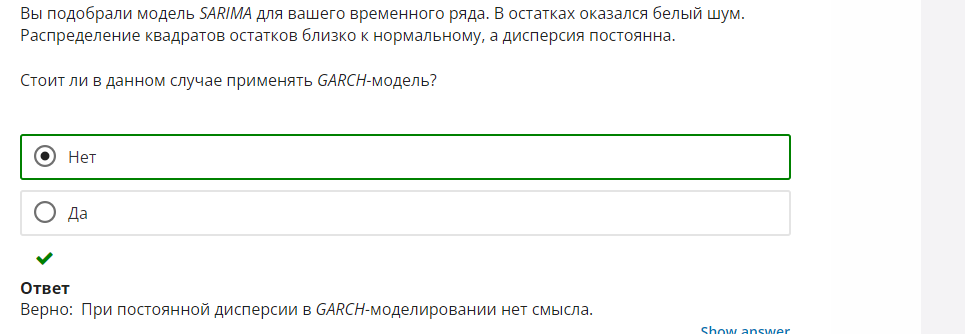

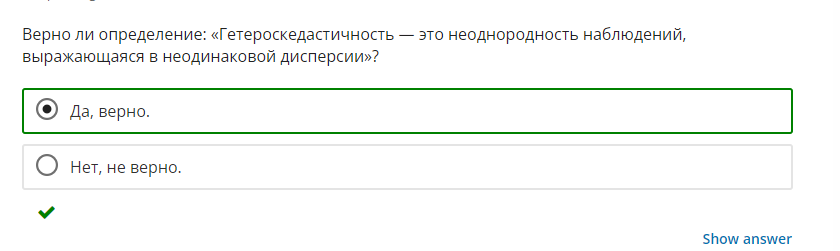

 Наиболее важным отличием работы с временными рядами от работы с другими данными является то, что к временным рядам нельзя применять обычный подход разбиения на тренировочную и тестовую выборки, тем более делая это случайным образом.

Таким образом, метод train_test_split не подходит, так как он разбивает данные случайным образом. В результате нарушается временная связь между данными ряда.

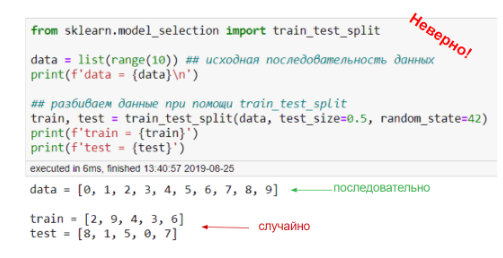

Для данных временного ряда разбиение на тренировочный и тестовый сеты нужно выполнять последовательно, иначе в алгоритм просочится информация из будущего, на которой он и обучается.

Последовательное разбиение может выглядеть так (train, test):

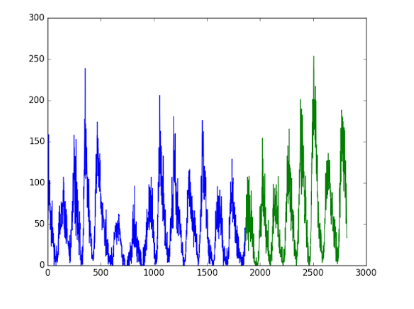

То есть в случае с данными на графике выше правильно будет разбить их как train = [0,1,2,3,4,5] и test = [6,7,8,9]. Соотношение объёма выборок, конечно, может быть другим, но главное — выборки должны идти последовательно.

АНАЛОГ КРОСС-ВАЛИДАЦИИ ДЛЯ ВРЕМЕННЫХ РЯДОВ

Если использовать обычную кросс-валидацию, информация из будущего снова просочится в алгоритм. Поэтому вместо кросс-валидации используются:

walk forward validation;
множественное разбиение.

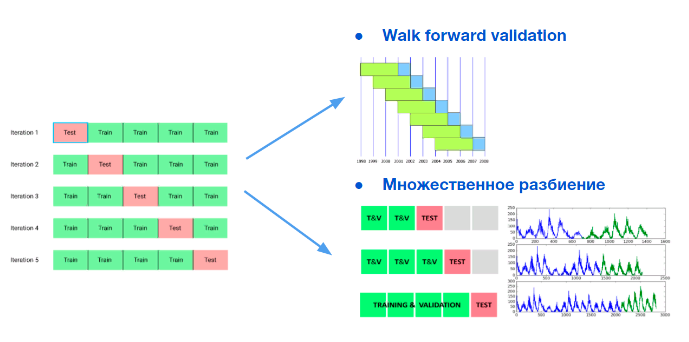

Обратите внимание на изображения выше. В обоих случаях мы также соблюдаем последовательность в разбиении — сравните с обычной кросс-валидацией (слева). Оба разбиения действуют по схожему принципу — делят выборки упорядоченно, чтобы подвыборка test всегда выбиралась после подвыборок train. Отличием будет то, что в walk forward validation размер обучающих выборок во всех фолдах (разбиениях) будет одинаковым, а во множественном разбиении в каждом новом фолде данные обучающей выборки накапливаются.

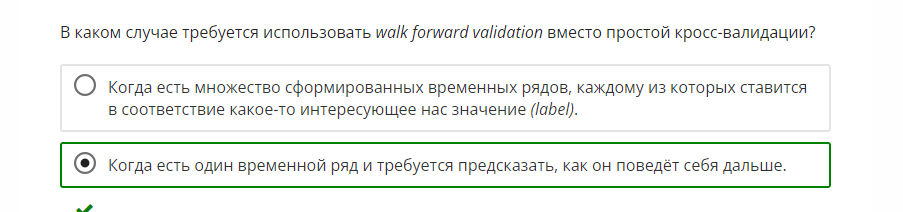

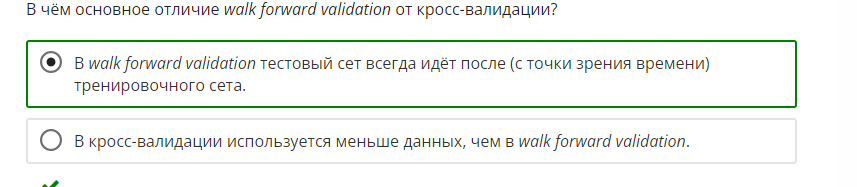

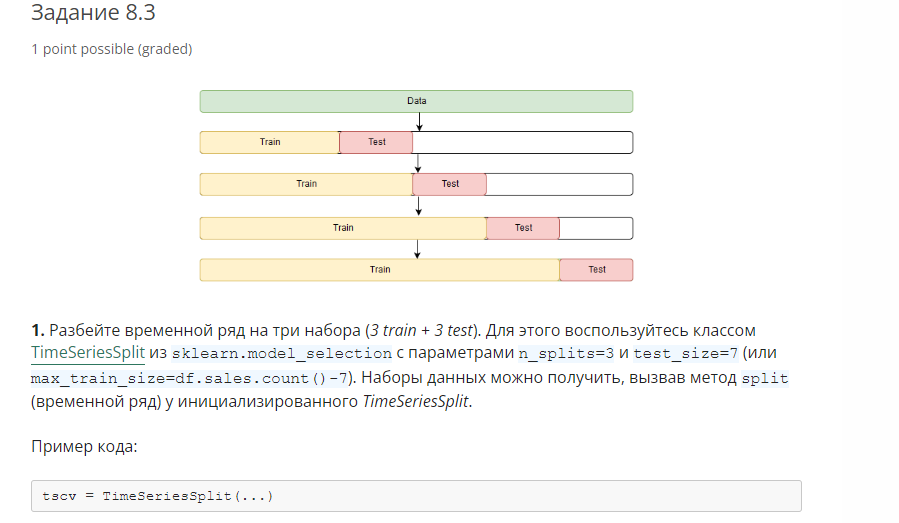

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html

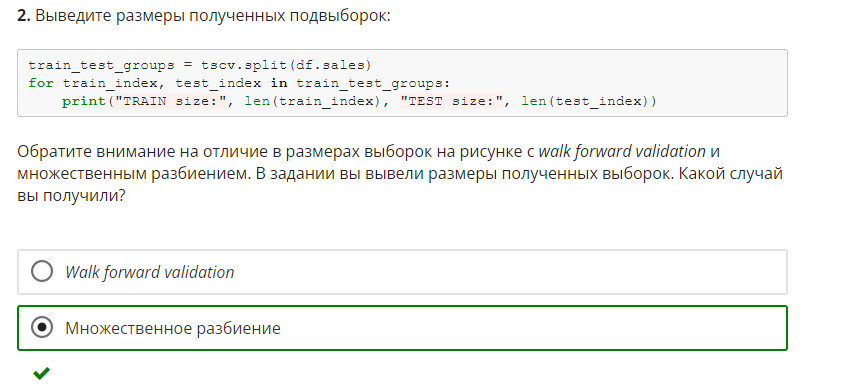